In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Food101

# Define transformations for the training and validation sets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download and load the training dataset
trainset = Food101(root='./data', split='train', transform=transform_train, download=True)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

# Download and load the test dataset
testset = Food101(root='./data', split='test', transform=transform_test, download=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)


100%|██████████| 4996278331/4996278331 [03:37<00:00, 22943489.07it/s]


Extracting ./data/food-101.tar.gz to ./data


In [ ]:
import torch
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

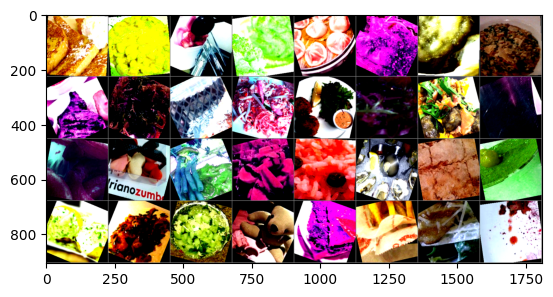

In [ ]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 101)  # 101 classes in Food-101 dataset

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


In [ ]:
import time

num_epochs = 50
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(testloader)
    test_losses.append(test_loss)

    accuracy = 100 * correct / total

    end_time = time.time()
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Time: {end_time - start_time:.2f}s")

    if accuracy >= 75:
        torch.save(model.state_dict(), f'model_{epoch+1}.pth')
        print(f"Achieved 75% accuracy at epoch {epoch+1}")

    if accuracy >= 80:
        print(f"Achieved 80% accuracy at epoch {epoch+1}")
        break

print('Finished Training')


Epoch 1/50, Train Loss: 2.8126, Test Loss: 1.3207, Accuracy: 64.69%, Time: 400.68s
Epoch 2/50, Train Loss: 1.9152, Test Loss: 0.9988, Accuracy: 72.59%, Time: 398.99s
Epoch 3/50, Train Loss: 1.6954, Test Loss: 0.8778, Accuracy: 75.65%, Time: 399.07s
Achieved 75% accuracy at epoch 3
Epoch 4/50, Train Loss: 1.5667, Test Loss: 0.7886, Accuracy: 78.17%, Time: 399.03s
Achieved 75% accuracy at epoch 4
Epoch 5/50, Train Loss: 1.4733, Test Loss: 0.7927, Accuracy: 78.11%, Time: 399.08s
Achieved 75% accuracy at epoch 5
Epoch 6/50, Train Loss: 1.4029, Test Loss: 0.7508, Accuracy: 79.06%, Time: 398.92s
Achieved 75% accuracy at epoch 6
Epoch 7/50, Train Loss: 1.3486, Test Loss: 0.7033, Accuracy: 80.39%, Time: 399.03s
Achieved 75% accuracy at epoch 7
Achieved 80% accuracy at epoch 7
Finished Training


In [ ]:
torch.save(model.state_dict(), f'model_final.pth')

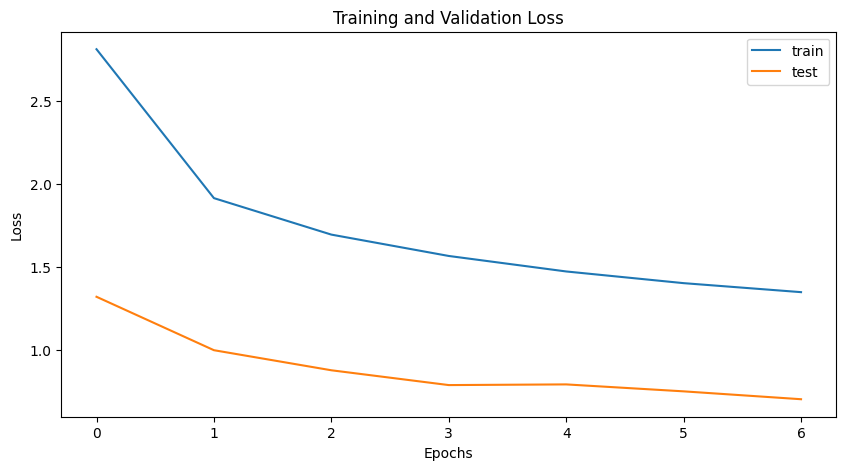

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()